In [1]:
import numpy as np
import tensorflow as tf
import pickle
from tensorflow.keras.preprocessing import image

import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display
import os
import random

%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
# For process to not allocate entire GPU memory

physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)

AssertionError: Not enough GPU hardware devices available

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
DATA_DIR = "/content/drive/MyDrive/CelebA_lowres"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")

In [8]:
def load_dataset_small(num_images_per_class_train=100, num_images_test=1000):
    x = []
    x_test = []
    
    # Create training set.
    for c in os.listdir(TRAIN_DIR):
        c_dir = os.path.join(TRAIN_DIR, c, 'images')
        c_imgs = os.listdir(c_dir)
        random.shuffle(c_imgs)
        for img_name_i in c_imgs[0:num_images_per_class_train]:
            img_i = image.load_img(os.path.join(c_dir, img_name_i))
            z = image.img_to_array(img_i)
            x.append(z)
    random.shuffle(x)
    
    # Create test set.
    test_dir = os.path.join(TEST_DIR, 'images')
    test_imgs = os.listdir(test_dir)
    random.shuffle(test_imgs)
    for img_name_i in test_imgs[0:num_images_test]:
        img_i = image.load_img(os.path.join(test_dir, img_name_i))
        z = image.img_to_array(img_i)
        x_test.append(z)
    return np.array(x), np.array(x_test)

In [ ]:
X_train_orig, X_test_orig = load_dataset_small()

x = X_train_orig/255.
x_test = X_test_orig/255.


print ("Number of training examples = " + str(x.shape[0]))
print ("Number of test examples = " + str(x_test.shape[0]))
print ("X_train shape: " + str(x.shape))

In [3]:
pkl_file = open("D:\Python Programs\CelebA_Highres_Split.pkl", 'rb')
data = pickle.load(pkl_file)
pkl_file.close()
x = data["Train"]
x_test = data["Test"]

In [44]:
(x, y), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()

169017344/169001437 [==============================] - 2s 0us/step


In [4]:
x = x.astype(np.float32)
x_test = x_test.astype(np.float32)

In [5]:
# for when payload is grayscale
# payload_train = np.mean(x, axis=-1)[:5000, :, :, np.newaxis]

# for when payload is rgb
payload_train = x[:5000]

host_train = x[np.random.choice(np.arange(x.shape[0]), size=payload_train.shape[0])][:5000]

# for when payload is grayscale
payload_test = np.mean(x_test, axis=-1)[:500, :, :, np.newaxis]

# for when payload is rgb
payload_test = x[:500]

host_test = x_test[np.random.choice(np.arange(x_test.shape[0]), size=payload_test.shape[0])][:500]

In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices((payload_train, host_train))

In [7]:
def normalize(payload, host):
    payload = tf.image.per_image_standardization(payload)
    host = tf.image.per_image_standardization(host)
    return payload, host

# Adding shuffle, normalization and batching operations to the dataset object
train_dataset = train_dataset.map(normalize).shuffle(5000).batch(256, drop_remainder=True)

In [8]:
# Instantiate the test Dataset class
test_dataset = tf.data.Dataset.from_tensor_slices((payload_test, host_test))
test_dataset = (test_dataset.map(normalize).batch(128, drop_remainder=True)).shuffle(500)

In [139]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
import tensorflow.keras.backend as K
from keras.callbacks import ModelCheckpoint,EarlyStopping

import matplotlib.pyplot as plt

import numpy as np
import os
import random
import scipy.misc
from tqdm import *
import cv2

In [9]:
tf.keras.backend.set_floatx('float32')
tf.keras.backend.floatx()

'float32'

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Concatenate, Input

class EncoderNetwork:
    def __init__(self, carrier_shape=(256, 256, 3), payload_shape=(256, 256, 1)):
        
#         super(EncoderModel, self).__init__()
        self.carrier_shape = carrier_shape
        self.payload_shape = payload_shape
        
    def _init_branch_payload(self, payload):

        self.branch__payload_conv_1 = Conv2D(16, 3, padding='same', activation='relu', kernel_initializer='he_normal', input_shape=self.payload_shape)(payload)
        self.branch__payload_conv_2 = Conv2D(16, 3, padding='same', activation='relu', kernel_initializer='he_normal')(self.branch__payload_conv_1)
        self.branch__payload_conv_3 = Conv2D(16, 3, padding='same', activation='relu', kernel_initializer='he_normal')(self.branch__payload_conv_2)
        self.branch__payload_conv_4 = Conv2D(16, 3, padding='same', activation='relu', kernel_initializer='he_normal')(self.branch__payload_conv_3)
        self.branch__payload_conv_5 = Conv2D(16, 3, padding='same', activation='relu', kernel_initializer='he_normal')(self.branch__payload_conv_4)
        self.branch__payload_conv_6 = Conv2D(16, 3, padding='same', activation='relu', kernel_initializer='he_normal')(self.branch__payload_conv_5)
        self.branch__payload_conv_7 = Conv2D(16, 3, padding='same', activation='relu', kernel_initializer='he_normal')(self.branch__payload_conv_6)
        
        self.payload_tensors = [self.branch__payload_conv_1, self.branch__payload_conv_2,\
                                self.branch__payload_conv_3, self.branch__payload_conv_4, self.branch__payload_conv_5,\
                                self.branch__payload_conv_6, self.branch__payload_conv_7]
    
    def _init_branch_carrier(self, carrier):
        
        self.branch_carrier_conv_1 = Conv2D(16, 3, padding='same', activation='relu', kernel_initializer='he_normal')(carrier)
        self.branch_carrier_concat_1 = Concatenate()([self.branch_carrier_conv_1, self.branch__payload_conv_1])
        
        self.branch_carrier_conv_2 = Conv2D(16, 3, padding='same', activation='relu', kernel_initializer='he_normal')(self.branch_carrier_concat_1)
        
        self.branch_carrier_conv_3 = Conv2D(16, 3, padding='same', activation='relu', kernel_initializer='he_normal')(self.branch_carrier_conv_2)
        self.branch_carrier_concat_2 = Concatenate()([self.branch_carrier_conv_3, self.branch__payload_conv_3])
        
        self.branch_carrier_conv_4 = Conv2D(16, 3, padding='same', activation='relu', kernel_initializer='he_normal')(self.branch_carrier_concat_2)
        
        self.branch_carrier_conv_5 = Conv2D(16, 3, padding='same', activation='relu', kernel_initializer='he_normal')(self.branch_carrier_conv_4)
        self.branch_carrier_concat_3 = Concatenate()([self.branch_carrier_conv_5, self.branch__payload_conv_5])
        
        self.branch_carrier_conv_6 = Conv2D(16, 3, padding='same', activation='relu', kernel_initializer='he_normal')(self.branch_carrier_concat_3)
        
        self.branch_carrier_conv_7 = Conv2D(16, 3, padding='same', activation='relu', kernel_initializer='he_normal')(self.branch_carrier_conv_6)
        self.branch_carrier_concat_4 = Concatenate()([self.branch_carrier_conv_7, self.branch__payload_conv_7])
        
        self.branch_carrier_conv_8 = Conv2D(16, 1, padding='same', activation='relu', kernel_initializer='he_normal')(self.branch_carrier_concat_4)
        self.branch_carrier_conv_9 = Conv2D(8, 1, padding='same', activation='relu', kernel_initializer='he_normal')(self.branch_carrier_conv_8)
        self.encoded_output = Conv2D(3, 1, padding='same', kernel_initializer='he_normal', name='encoded_output')(self.branch_carrier_conv_9)
        
        self.carrier_tensors = [self.branch_carrier_conv_1, self.branch_carrier_concat_1,\
                               self.branch_carrier_conv_2, self.branch_carrier_conv_3, self.branch_carrier_concat_2,\
                               self.branch_carrier_conv_4, self.branch_carrier_conv_5, self.branch_carrier_concat_3,\
                               self.branch_carrier_conv_6, self.branch_carrier_conv_7, self.branch_carrier_concat_4,\
                               self.branch_carrier_conv_8, self.branch_carrier_conv_9, self.encoded_output]
    
    def get_network(self, carrier, payload):
        
        self._init_branch_payload(payload)
        self._init_branch_carrier(carrier)
        
        return self.encoded_output
# def make_encoder(input_size):
#     input_S = Input(shape=(input_size))
#     input_C= Input(shape=(input_size))

#     x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_3x3')(input_S)
#     x4 = Conv2D(10, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_4x4')(input_S)
#     x5 = Conv2D(5, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_5x5')(input_S)
#     x = concatenate([x3, x4, x5])
    
#     x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_3x3')(x)
#     x4 = Conv2D(10, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_4x4')(x)
#     x5 = Conv2D(5, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_5x5')(x)
#     x = concatenate([x3, x4, x5])
    
#     x = concatenate([input_C, x])
    
#     x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_3x3')(x)
#     x4 = Conv2D(10, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_4x4')(x)
#     x5 = Conv2D(5, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_5x5')(x)
#     x = concatenate([x3, x4, x5])
    
#     x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_3x3')(x)
#     x4 = Conv2D(10, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_4x4')(x)
#     x5 = Conv2D(5, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_5x5')(x)
#     x = concatenate([x3, x4, x5])
    
#     x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_3x3')(x)
#     x4 = Conv2D(10, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_4x4')(x)
#     x5 = Conv2D(5, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_5x5')(x)
#     x = concatenate([x3, x4, x5])
    
#     x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_3x3')(x)
#     x4 = Conv2D(10, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_4x4')(x)
#     x5 = Conv2D(5, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_5x5')(x)
#     x = concatenate([x3, x4, x5])
    
#     x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_3x3')(x)
#     x4 = Conv2D(10, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_4x4')(x)
#     x5 = Conv2D(5, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid5_5x5')(x)
#     x = concatenate([x3, x4, x5])
    
#     output_Cprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_C')(x)
    
#     return Model(inputs=[input_S, input_C],
#                  outputs=output_Cprime,
#                  name = 'Encoder')

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Concatenate, Input

class DecoderNetwork:
    def __init__(self, target_image_shape = (256, 256, 1)):
#         super(DecoderModel, self).__init__()
        self.target_image_shape = target_image_shape
        
    def _init_network(self, input_):

        self.conv_1 = Conv2D(16, 3, padding='same', activation='relu', kernel_initializer='he_normal')(input_)
        self.conv_2 = Conv2D(16, 3, padding='same', activation='relu', kernel_initializer='he_normal')(self.conv_1)
        self.conv_3 = Conv2D(8, 3, padding='same', activation='relu', kernel_initializer='he_normal')(self.conv_2)
        self.conv_4 = Conv2D(8, 3, padding='same', activation='relu', kernel_initializer='he_normal')(self.conv_3)
        self.conv_5 = Conv2D(3, 3, padding='same', activation='relu', kernel_initializer='he_normal')(self.conv_4)
        self.conv_6 = Conv2D(3, 3, padding='same', activation='relu', kernel_initializer='he_normal')(self.conv_5)
        self.decoded_output = Conv2D(self.target_image_shape[-1], self.target_image_shape[-1], padding='same', activation='relu', kernel_initializer='he_normal', name='decoded_output')(self.conv_6)
        
        self.decoder_tensors = [self.conv_1, self.conv_2,\
                                self.conv_3, self.conv_4, self.conv_5,\
                                self.conv_6, self.decoded_output]
    
    def get_network(self, encoder_output):
        
        self._init_network(encoder_output)

        return self.decoded_output

# def make_decoder(input_size, fixed=False):
    
#     # Reveal network
#     reveal_input = Input(shape=(input_size))
    
#     # Adding Gaussian noise with 0.01 standard deviation.
#     input_with_noise = GaussianNoise(0.01, name='output_C_noise')(reveal_input)
    
#     x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_3x3')(input_with_noise)
#     x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_4x4')(input_with_noise)
#     x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_5x5')(input_with_noise)
#     x = concatenate([x3, x4, x5])
    
#     x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_3x3')(x)
#     x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_4x4')(x)
#     x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_5x5')(x)
#     x = concatenate([x3, x4, x5])
    
#     x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_3x3')(x)
#     x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_4x4')(x)
#     x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_5x5')(x)
#     x = concatenate([x3, x4, x5])
    
#     x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_3x3')(x)
#     x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_4x4')(x)
#     x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_5x5')(x)
#     x = concatenate([x3, x4, x5])
    
#     x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_3x3')(x)
#     x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_4x4')(x)
#     x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev5_5x5')(x)
#     x = concatenate([x3, x4, x5])
    
#     output_Sprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='tanh', name='output_S')(x)
    
#     if not fixed:
#         return Model(inputs=reveal_input,
#                      outputs=output_Sprime,
#                      name = 'Decoder')
#     else:
#         return Network(inputs=reveal_input,
#                          outputs=output_Sprime,
#                          name = 'DecoderFixed')

In [14]:
carrier_image_shape=(256, 256, 3)
payload_image_shape=(256, 256, 3)

encoder_network = EncoderNetwork(
    carrier_shape=carrier_image_shape, payload_shape=payload_image_shape)
decoder_network = DecoderNetwork(target_image_shape=payload_image_shape)


In [143]:
def make_model(input_size):
    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size))
    
    encoder = make_encoder(input_size)
    
    decoder = make_decoder(input_size)
    decoder.compile(optimizer='adam', loss=rev_loss)
    decoder.trainable = False
    
    output_Cprime = encoder([input_S, input_C])
    output_Sprime = decoder(output_Cprime)

    autoencoder = Model(inputs=[input_S, input_C],
                        outputs=concatenate([output_Sprime, output_Cprime]))
    autoencoder.compile(optimizer='adam', loss=full_loss)
    
    return encoder, decoder, autoencoder

In [15]:
input_carrier = Input(shape=carrier_image_shape, name='input_carrier')
input_payload = Input(shape=payload_image_shape, name='input_payload')

In [16]:
encoded_output = encoder_network.get_network(input_carrier, input_payload)
decoded_output = decoder_network.get_network(encoded_output)

In [17]:
steganography_model = Model(inputs=[input_carrier, input_payload], outputs=[encoded_output, decoded_output])

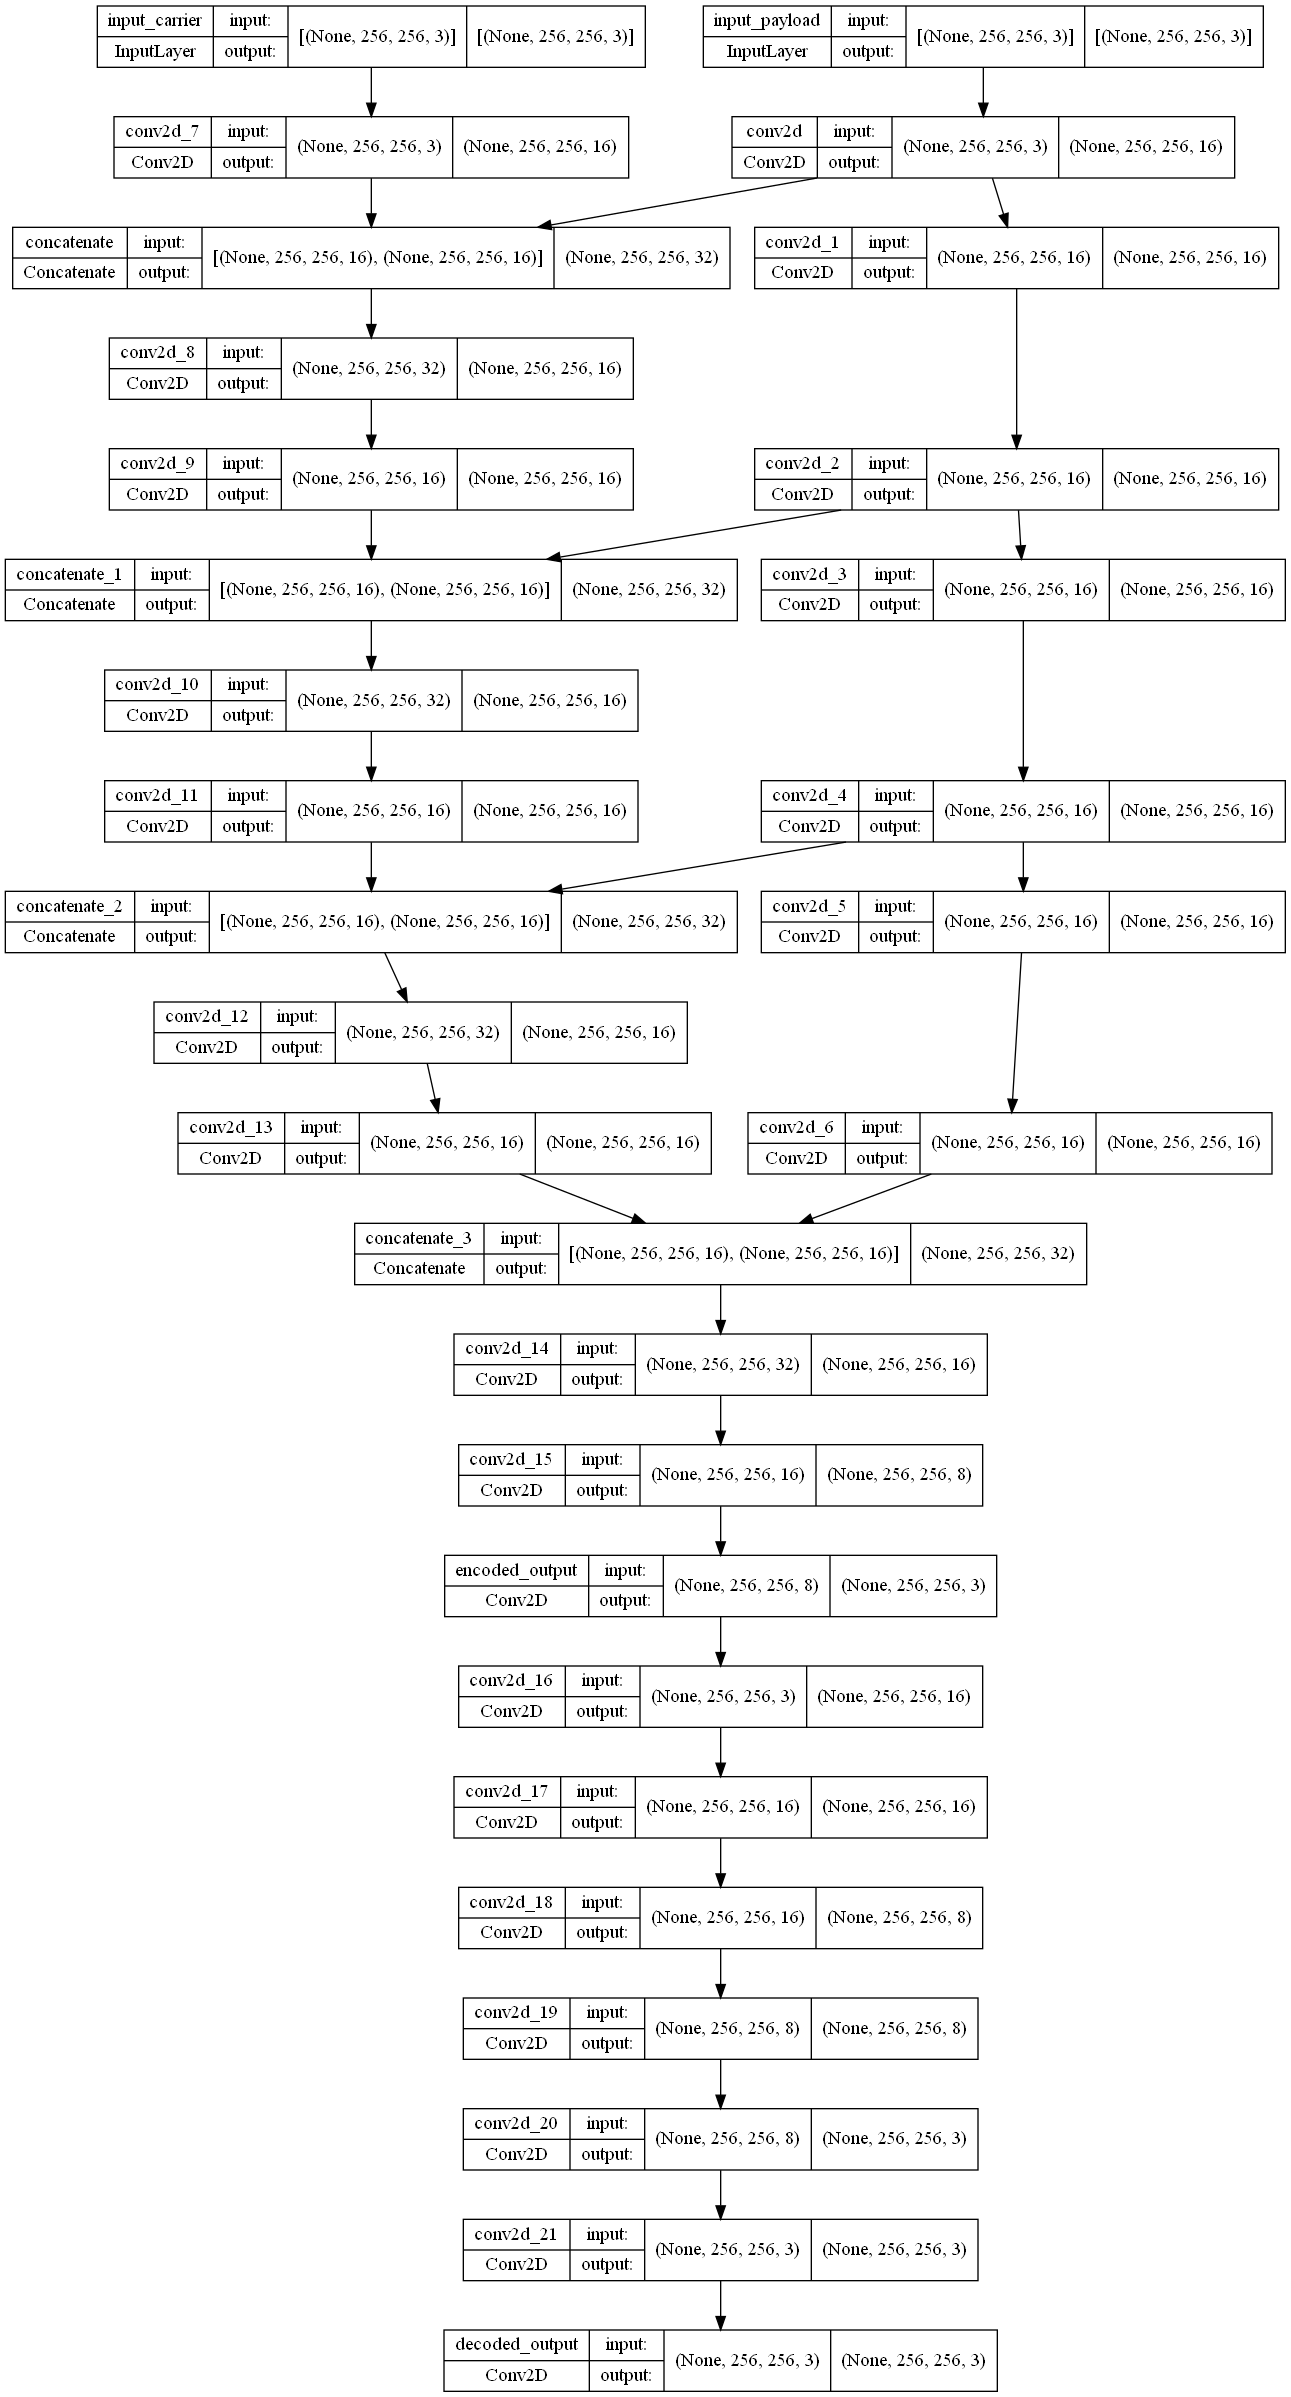

In [18]:
from tensorflow.keras.utils import plot_model
plot_model(steganography_model, show_shapes=True)

In [19]:
steganography_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_carrier (InputLayer)     [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_payload (InputLayer)     [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_7 (Conv2D)              (None, 256, 256, 16  448         ['input_carrier[0][0]']          
                                )                                                             

In [20]:
# Defining Loss Function

@tf.function
def loss_function(payload, host, encoder_output, decoder_output):
    
    loss = tf.math.reduce_mean(tf.math.squared_difference(payload, decoder_output)\
                           + tf.math.squared_difference(host, encoder_output))
        
    return loss

In [21]:
def custom_loss(input_):
    def loss(y_true, y_pred):
        return tf.math.reduce_mean(tf.math.squared_difference(y_true, y_pred))
    return loss 

In [22]:
optimizer = tf.keras.optimizers.Adam(0.001)

In [23]:
a = None
for payload, host in train_dataset.batch(5000):
    a = host
    break

In [24]:
test_loss = tf.keras.metrics.Mean(name='test_loss')
train_loss = tf.keras.metrics.Mean(name='train_loss')

@tf.function
def train_step(payload, host):
    with tf.GradientTape() as tape:
        encoded_host, decoded_payload = steganography_model([host, payload])
        loss = loss_function(payload, host, encoded_host, decoded_payload)
        train_loss(loss)
    gradients = tape.gradient(loss, steganography_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, steganography_model.trainable_variables))
    
    train_host_psnr = tf.reduce_mean(tf.image.psnr(host, encoded_host, 18))
    train_payload_psnr = tf.reduce_mean(tf.image.psnr(payload, decoded_payload, 18))
    
    return train_host_psnr, train_payload_psnr



@tf.function
def test_step(payload, host):
    encoded_host, decoded_payload = steganography_model([host, payload])
    t_loss = loss_function(payload, host, encoded_host, decoded_payload)
    test_loss(t_loss)
    
    test_host_psnr = tf.reduce_mean(tf.image.psnr(host, encoded_host, 18))
    test_payload_psnr = tf.reduce_mean(tf.image.psnr(payload, decoded_payload, 18))
    
    return test_host_psnr, test_payload_psnr

EPOCHS = 250
SUMMARY_DIR = './summary'

import time


for epoch in range(EPOCHS):
    start = time.time()
    for payload, host in train_dataset:
        train_host_psnr, train_payload_psnr = train_step(payload, host)

    for payload, host in test_dataset:
        test_host_psnr, test_payload_psnr = test_step(payload, host)

    elapsed = time.time() - start
    print('elapsed: %f' % elapsed)

    template = 'Epoch {}, Train Loss: {}, Test Loss: {}, TrainH PSNR: {}, TrainP PSNR: {}, TestH PSNR: {}, TestP PSNR: {}'
    print(template.format(epoch+1, train_loss.result(), test_loss.result(), train_host_psnr,\
                         train_payload_psnr, test_host_psnr, test_payload_psnr))

    # Reset the metrics for the next epoch
    test_loss.reset_states()

print('Training Finished.')

: 

: 

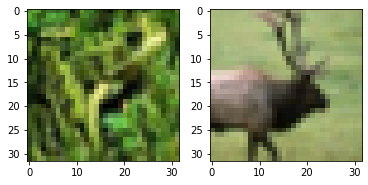

In [26]:
example_ids = np.arange(len(host_test))[:100]
example_id = np.random.choice(example_ids)

# showing host 
fig, axs = plt.subplots(ncols=2)

host_example = host_test.astype(int)[example_id]
payload_example = payload_test.astype(int)[example_id]
# payload_example = np.concatenate((payload_example, np.zeros_like(payload_example), np.zeros_like(payload_example)), axis=-1)
axs[0].imshow(host_example)
axs[1].imshow(payload_example)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


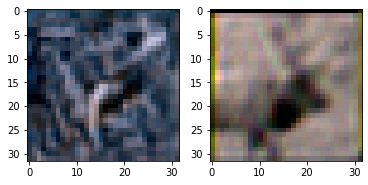

In [27]:
fig, axs = plt.subplots(ncols=2)

inference_dataset = tf.data.Dataset.from_tensor_slices((host_test[example_ids], payload_test[example_ids])).batch(len(example_ids))
for host, payload in inference_dataset:
    encoded_host, decoded_payload = steganography_model([host, payload])
    host_outputs = encoded_host.numpy()
    payload_output = decoded_payload.numpy()

host_output = host_outputs.astype(int)[example_id]
payload_output = payload_output.astype(int)[example_id]

    
# payload_output = np.concatenate((payload_output, np.zeros_like(payload_output), np.zeros_like(payload_output)), axis=-1)
axs[0].imshow(host_output)
axs[1].imshow(payload_output)